# Variation of the Baseline Model
Different to the Baseline are:

1. Using InceptionV3 as Encoder-Part (CNN)
1. The usage of GRU layers instead of LSTM layers on the Decoder-Part
1. Preprocessing of captions improved
1. VOCABSIZE = 5001

In [1]:
# Install packages
!pip install rouge-score

In [2]:
import os  # operating system access
import sys  # system specific operations
import datetime as dt  # datetime handling

import numpy as np  # linear algebra
import pandas as pd  # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.model_selection import train_test_split  # data preperation

import tensorflow as tf  # tensorflow
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import layers, Input, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras import backend as K
from tensorflow.keras.utils import plot_model
import tensorflow_addons as tfa
import tensorboard as tb

import tqdm  # progress bars
import json
import codecs
import pickle

import warnings
warnings.simplefilter(action='ignore')

import matplotlib.pyplot as plt

import nltk.translate.bleu_score as ntbs  # BLEU scoring basics
import rouge_score.rouge_scorer as rouge_scorer  # ROUGE scoring basics

## Configuration

In [3]:
# Runtime config
RUN_ON_KAGGLE = False
EPOCHS = 50
RUN_TRAINING = True  # Train the model during run
USE_CONFIG_TIMESTAMP = True  # Use below defined timestamp FN_TIMESTAMP if missing
SAVE_MODEL = True  # Write model to hd5 file
LOG_MODEL = True  # Write tensorboard and model history logs during training
RUN_DATA_CHECK = False  # Do a basic check on the input data

# Model config
# Config 1
MODEL_NAME = 'InceptV3_GRU_NoAttention_CustEmbedding_v2'
BATCH_SIZE = 64
EARLY_STOPPING_PATIENT = 5
EMBEDDING_DIM = 256
UNITS = 512
VOCAB_SIZE = 5001

# Config 2 (20210429-172359)
#MODEL_NAME = 'InceptV3_GRU_NoAttention_CustEmbedding_768-units-all'
#BATCH_SIZE = 64
#EARLY_STOPPING_PATIENT = 5
#EMBEDDING_DIM = 256
#UNITS = 512 + 256


# GPU/CPU config
MEMORY_OF_GPU = 6000  # MBytes

# Tensorboard view config
TENSORBOARD_SHOW_INLINE = False
# Launch tensorboard
# True: From that notebook, False: connect to already running tensorboard
TENSORBOARD_LAUNCH = False

# Directories and filenames
if RUN_ON_KAGGLE:
    FP_CAPTIONS = '../input/flickr8k/captions.txt'
    DIR_IMAGES = '../input/flickr8k/Images/'
    DIR_IMAGE_FEATURES = '../input/aida-image-captioning/Images/'
    DIR_MODEL_STORE = './models/'
    DIR_MODEL_LOG = './models/'
    DIR_RESULT_STORE = './results/'
    DIR_TENSORBOARD_LOG = './tensorboard/'
else:
    FP_CAPTIONS = '../data/raw/flickr8k/captions.txt'
    DIR_IMAGES = '../data/raw/flickr8k/Images/'
    DIR_IMAGE_FEATURES = '../data/interim/aida-image-captioning_inceptionv3_v2/Images/'
    DIR_MODEL_STORE = f'../models/{MODEL_NAME}/'
    DIR_MODEL_LOG = f'../models/logs/{MODEL_NAME}/'
    DIR_RESULT_STORE = f'../data/results/{MODEL_NAME}/'
    DIR_TENSORBOARD_LOG = './tensorboard_logs/scalars/'

# Misc config
if RUN_ON_KAGGLE:
    # Create specified directories
    !mkdir results
    !mkdir models    
    !mkdir tensorboard
    !mkdir models/$MODEL_NAME

    sys.path.insert(0, '../input/aida-metrics-functions')  # custom metrics implementation
    import metrics as met  # custom metrics BLUE-1 pecsision and ROUGE-L recall
else:
    !mkdir ../models/$MODEL_NAME
    !mkdir ../data/results/$MODEL_NAME
    import src.models.metrics as met

mkdir: das Verzeichnis »../models/InceptV3_GRU_NoAttention_CustEmbedding_v2“ kann nicht angelegt werden: Die Datei existiert bereits
mkdir: das Verzeichnis »../data/results/InceptV3_GRU_NoAttention_CustEmbedding_v2“ kann nicht angelegt werden: Die Datei existiert bereits


## Init

In [4]:
timestamp_str = None
FN_TIMESTAMP = "20210503-193008"
FN_MODEL2LOAD = f"{MODEL_NAME}_{FN_TIMESTAMP}.h5"
FN_HIST2LOAD = f"{MODEL_NAME}_{FN_TIMESTAMP}.pickle"

# To get access to a GPU instance you can use the `change runtime type` and set the option to `GPU` from the `Runtime` tab  in the notebook
# Checking the GPU availability for the notebook
#tf.test.gpu_device_name()

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    # Create virtual GPUs
    try:
        tf.config.experimental.set_virtual_device_configuration(
            #OK, but solwer: 
            #gpus[0], [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=2.5*1024),
            #      tf.config.experimental.VirtualDeviceConfiguration(memory_limit=2.5*1024),
            #      tf.config.experimental.VirtualDeviceConfiguration(memory_limit=2.5*1024),
            #      tf.config.experimental.VirtualDeviceConfiguration(memory_limit=2.5*1024)],
            #OK
            gpus[0], [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=MEMORY_OF_GPU//2),
                      tf.config.experimental.VirtualDeviceConfiguration(memory_limit=MEMORY_OF_GPU//2)],
            #Error using NCCL automatically on mirrored strategy: gpus[0], [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=10*1024)],
        )

        tf.config.experimental.set_virtual_device_configuration(
            #OK, but solwer: 
            #gpus[1], [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=2.5*1024),
            #      tf.config.experimental.VirtualDeviceConfiguration(memory_limit=2.5*1024),
            #      tf.config.experimental.VirtualDeviceConfiguration(memory_limit=2.5*1024),
            #      tf.config.experimental.VirtualDeviceConfiguration(memory_limit=2.5*1024)],
            #OK 
            gpus[1], [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=MEMORY_OF_GPU//2),
                      tf.config.experimental.VirtualDeviceConfiguration(memory_limit=MEMORY_OF_GPU//2)],
            #Error using NCCL automatically on mirrored strategy: gpus[1], [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=10*1024)],            
        )
    except:
        # Virtual devices must be set before GPUs have been initialized
        print("Warning: During GPU handling.")
        pass
    finally:
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPU,", len(logical_gpus), "Logical GPUs\n")

# Set runtime context and batch size
l_rtc_names = [
    "multi-GPU_MirroredStrategy",
    "multi-GPU_CentralStorageStrategy",
    "1-GPU",
    "CPUs",
    "multi-GPU_MirroredStrategy_NCCL-All-Reduced",
]
l_rtc = [
    tf.distribute.MirroredStrategy().scope(),
    tf.distribute.experimental.CentralStorageStrategy().scope(),
    tf.device("/GPU:0"),
    tf.device("/CPU:0"),
    tf.distribute.MirroredStrategy(cross_device_ops=tf.distribute.NcclAllReduce()).scope(),
]
if len(gpus) == 0:
    rtc_idx = 3
    batch_size = 64

elif len(gpus) == 1:
    rtc_idx = 2
    batch_size = 4*256

elif len(gpus) > 1:
    rtc_idx = 0
    batch_size = 8*256

runtime_context = l_rtc[rtc_idx]

print(f"\nRuntime Context: {l_rtc_names[rtc_idx]}")
print(f"Recommended Batch Size: {batch_size} datasets")

1 Physical GPU, 2 Logical GPUs

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
INFO:tensorflow:ParameterServerStrategy (CentralStorageStrategy if you are using a single machine) with compute_devices = ['/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1'], variable_device = '/device:CPU:0'
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')

Runtime Context: 1-GPU
Recommended Batch Size: 1024 datasets


## Helper functions

In [5]:
def preproc_text(texts, top_freq_words=VOCAB_SIZE-1):
    """
    - Adds <start> to the beginning of texts to the inputs
    - Adds <end> to the end of texts
    Input: texts: list of sentences
    Output: - tokenized, padded text with <start> token for using as input in decoder
            - tokenized, padded text with <end> token for using as target in decoder
            - tokenizer
            - max_seq_len
    """

    print('Creating and fitting tokenizer...')
    tokenizer_fit_data = ['<start> ' + s + ' <end>' for s in texts]

    # create tokenizer for captions + <start> and <end> tags
    tokenizer = Tokenizer(filters='!"#$%&()*+,-./:;?@[\\]^_`{|}~\t\n',
                         num_words=top_freq_words)
    tokenizer.fit_on_texts(tokenizer_fit_data)
    tokenizer.word_index['<pad>'] = 0
    tokenizer.index_word[0] = '<pad>'
    print('Creating and fitting tokenizer done')

    print('Create text input sequences...')
    # add <start> tag before every caption and tokenize + pad ('post')
    enc_input_data = ['<start> ' + s for s in texts]
    enc_input_token_seqs = tokenizer.texts_to_sequences(enc_input_data)
    # if no "maxlen" defined then pad_sequences takes the longest sequence as max_len
    enc_input_prep = pad_sequences(enc_input_token_seqs, padding='post')
    print('Create text input sequences done')

    print('Create text target sequences...')
    # add <start> tag before every caption and tokenize + pad ('post')
    enc_target_data = [s + ' <end>' for s in texts]
    enc_target_token_seqs = tokenizer.texts_to_sequences(enc_target_data)
    # if no "maxlen" defined then pad_sequences takes the longest sequence as max_len
    enc_target_prep = pad_sequences(enc_target_token_seqs, padding='post')
    print('Create text target sequences done')

    print('\n\n')

    # show some texts processed
    for i  in range(2):
        print(f'               {i} orig: {texts[i]}')
        print(f'              {i} input: {enc_input_data[i]}')
        print(f' {i} preprocessed input: {enc_input_prep[i]}')
        print(f'             {i} target: {enc_target_data[i]}')
        print(f'{i} preprocessed target: {enc_target_prep[i]}')
        print()

    print('\n\n')
    print(f' preprocessed input shape: {enc_input_prep.shape}')
    print(f'preprocessed target shape: {enc_target_prep.shape}')

    return enc_input_prep, enc_target_prep, tokenizer, enc_input_prep.shape[-1]  # last dim is the length of the sequences        


class History_trained_model(object):
    """Helper class for saving training history"""
    def __init__(self, history, epoch, params):
        self.history = history
        self.epoch = epoch
        self.params = params


def save_hist(path, history):
    """Saves the training history to file"""
    with open(path, 'wb') as file:
        model_history = History_trained_model(history.history, history.epoch, history.params)
        pickle.dump(model_history, file, pickle.HIGHEST_PROTOCOL)        


def load_hist(path):
    """Loads the training history from file"""
    with open(path, 'rb') as file:
        history = pickle.load(file)
    return history


def lr_scheduler(epoch, lr):
  """
  Learning rate scheduler for keras callbacks
  Returns a custom learning rate that decreases as epochs progress.
  """
  tf.summary.scalar('learning rate', data=lr, step=epoch)
  return lr

## Load Data

In [6]:
# Picture captions
df_cap = pd.read_csv(FP_CAPTIONS)
display(df_cap.head())

,image,caption
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...


# Check Data

In [7]:
if RUN_DATA_CHECK:
    # Number of captions per image
    print(df_cap.groupby('image').agg(cap_count=('caption','count')).describe())

    # Test if images are there for every entry
    img_file_not_exist = []

    df = df_cap['image'].unique()
    for image in tqdm.tqdm_notebook(df, total=len(df)):
        if not os.path.exists(os.path.join(DIR_IMAGES, image)):
            img_file_not_exist.append(image)

    print(f'Number of image files not exists in "{DIR_IMAGES}" directory: {len(img_file_not_exist)}')

    # test if images features are there for every entry
    img_file_not_exist = []
    for image in tqdm.tqdm_notebook(df_cap['image'].unique()):
        if not os.path.exists(os.path.join(DIR_IMAGE_FEATURES, image.replace('.jpg', '.npy'))):
            img_file_not_exist.append(image)

    print(f'Number of image feature files not exists in "{DIR_IMAGE_FEATURES}" directory: {len(img_file_not_exist)}')

## Preprocess Captions

In [8]:
enc_input_prep, enc_target_prep, tokenizer, max_seq_len = preproc_text(df_cap['caption'].values)

Creating and fitting tokenizer...
Creating and fitting tokenizer done
Create text input sequences...
Create text input sequences done
Create text target sequences...
Create text target sequences done



               0 orig: A child in a pink dress is climbing up a set of stairs in an entry way .
              0 input: <start> A child in a pink dress is climbing up a set of stairs in an entry way .
 0 preprocessed input: [  2   1  43   4   1  90 172   7 119  51   1 393  12 394   4  28 670   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0]
             0 target: A child in a pink dress is climbing up a set of stairs in an entry way . <end>
0 preprocessed target: [  1  43   4   1  90 172   7 119  51   1 393  12 394   4  28 670   3   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0]

               1 orig: A girl going into a wooden building .
              1 input: <start> A girl going into a wooden building .
 1 pre

## Create Train-Test Split

In [9]:
# Create 80,20 % split on the images
_, test_img_names = train_test_split(df_cap['image'].unique(), test_size=0.2, random_state=42)
df_cap['is_test'] = df_cap['image'].isin(test_img_names)
display(df_cap.head(2))

# Trainset
train_enc_input_prep = enc_input_prep[df_cap[~df_cap['is_test']].index]
train_enc_target_prep = enc_target_prep[df_cap[~df_cap['is_test']].index]
train_image_feature_names = df_cap[~df_cap['is_test']]['image'].map(lambda x: os.path.join(DIR_IMAGE_FEATURES, x.replace('.jpg', '.npy'))).values

# Testset
test_enc_input_prep = enc_input_prep[df_cap[df_cap['is_test']].index]
test_enc_target_prep = enc_target_prep[df_cap[df_cap['is_test']].index]
test_image_feature_names = df_cap[df_cap['is_test']]['image'].map(lambda x: os.path.join(DIR_IMAGE_FEATURES,x.replace('.jpg', '.npy'))).values

# show train_image_features
train_image_feature_names.shape, train_image_feature_names[:2]

,image,caption,is_test
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...,False
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .,False


((32360,),
 array(['../data/interim/aida-image-captioning_inceptionv3_v2/Images/1000268201_693b08cb0e.npy',
        '../data/interim/aida-image-captioning_inceptionv3_v2/Images/1000268201_693b08cb0e.npy'],
       dtype=object))

## Setup Data Generator

In [10]:
class MyDataGenerator(tf.keras.utils.Sequence):
    """Custom class for providing the data to the model"""
    def __init__(self, 
                 image_names: np.ndarray, 
                 cap_inputs: np.ndarray, 
                 cap_targets: np.ndarray, 
                 batch_size: int, 
                 shuffle: bool = True):
        """
        Constructor
        Arguments:
            image_name: Name of the imaga file
            cap_inputs: Word vectors of known captions used for training and test,
                        containing <start> keyword
            cap_targets: Word vectors of known captions used for prediction,
                         containing <end> keyword
            batch_size: Batch size to use
            shuffle: True: do shuffeling
                     False: use order as is
        """
        self.image_names = image_names
        self.cap_inputs = cap_inputs
        self.cap_targets = cap_targets
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.on_epoch_end()


    def on_epoch_end(self):
        """Updates indexes after each epoch"""
        self.indexes = np.arange(len(self.image_names))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)


    def __len__(self):
        """Returns the number of batch in the sequence."""
        return int(np.floor(len(self.image_names) / self.batch_size))


    def __getitem__(self, index):
        """Generate one batch of data using the index"""
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Generate data
        imgs, cap_ins, cap_outs = [], [], []
        for i in indexes:
            imgs.append( np.load(self.image_names[i]) )
            cap_ins.append( self.cap_inputs[i] )
            cap_outs.append( self.cap_targets[i] )
        return (np.array(imgs), np.array(cap_ins)),  np.array(cap_outs)

In [11]:
# Init generators
train_gen = MyDataGenerator(train_image_feature_names, train_enc_input_prep, train_enc_target_prep, batch_size=BATCH_SIZE, shuffle=True)
test_gen = MyDataGenerator(test_image_feature_names, test_enc_input_prep, test_enc_target_prep, batch_size=BATCH_SIZE, shuffle=False)

# Create Encoder-Decoder model for Training/Test

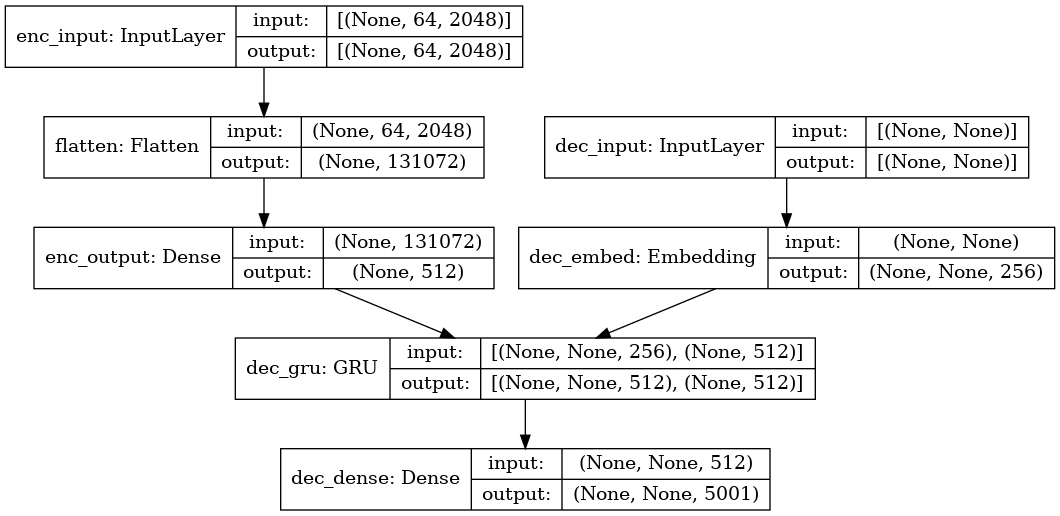

Training:   0%|           0/50 ETA: ?s,  ?epochs/s

Epoch 1/50


0/505           ETA: ?s - 

Epoch 2/50


0/505           ETA: ?s - 

Epoch 3/50


0/505           ETA: ?s - 

Epoch 4/50


0/505           ETA: ?s - 

Epoch 5/50


0/505           ETA: ?s - 

Epoch 6/50


0/505           ETA: ?s - 

Epoch 7/50


0/505           ETA: ?s - 

Epoch 8/50


0/505           ETA: ?s - 

Epoch 9/50


0/505           ETA: ?s - 

Epoch 10/50


0/505           ETA: ?s - 

Model history for InceptV3_GRU_NoAttention_CustEmbedding_v2 saved to: ../models/InceptV3_GRU_NoAttention_CustEmbedding_v2/InceptV3_GRU_NoAttention_CustEmbedding_v2_20210503-193008.pickle
Model InceptV3_GRU_NoAttention_CustEmbedding_v2 saved to: ../models/InceptV3_GRU_NoAttention_CustEmbedding_v2/InceptV3_GRU_NoAttention_CustEmbedding_v2_20210503-193008.h5


In [12]:
# Config model dimensions
#VOCAB_SIZE = len(tokenizer.index_word)

# Create own loss function
# means: mask out padded targets
def loss_func(targets, preds):
    # last layer has softmax activation => from_logits=False
    #sparse_cat_ce = SparseCategoricalCrossentropy()
    sparse_cat_ce = SparseCategoricalCrossentropy(from_logits=True)
    mask = K.cast(K.greater(targets, 0), dtype=tf.int64)    
    # calc cross entropy masked
    loss = sparse_cat_ce(targets, preds, sample_weight=mask)
    return loss


# Create own accuracy function
def accuracy_func(targets, preds):
    real_preds = K.cast(K.argmax(preds, axis=-1), dtype=tf.float32)
    correct = K.cast(K.equal(targets, real_preds), dtype=tf.float32)
    # mask out 0 padded elements
    mask = K.cast(K.greater(targets, 0), dtype=tf.float32)
    n_correct = K.sum(mask * correct)
    n_total = K.sum(mask)
    return n_correct/n_total


if RUN_TRAINING:
    # Set timestamp of training
    timestamp_str = dt.datetime.now().strftime("%Y%m%d-%H%M%S")  # set timestamp for current run

    def create_base_enc_dec_model(
            enc_input_shape: tuple,
            output_seq_length: int,
            embedding_dim: int,
            vocab_size: int,
            units: int) -> tf.keras.Model:
        """
        Build up the encoder- and decoder-part for training and testing purpose

        Arguments:
            enc_input_shape: Tuple of input dimensions of the encoder
            output_seq_length: Max length of caption sequence to predict
            embedding_dim: Length of used word vectors
            vocab_size: Number of words within the vocabulary
            units: Number of CNN and RNN units to use
        Returns:
            compiled keras model
        """
        # ENCODER
        enc_input = Input(shape=enc_input_shape, name='enc_input')   
        enc_output = layers.Flatten()(enc_input) # BSx64x2048 => BSx131072
        enc_output = layers.Dense(units, activation='relu', name='enc_output')(enc_output)

        # DECODER
        dec_input = Input(shape=(None,), name='dec_input')

        dec_embed_out = layers.Embedding(
            input_dim=vocab_size,
            output_dim=embedding_dim,
            name='dec_embed')(dec_input)

        dec_gru_out, _ = layers.GRU(
            units,
            return_sequences=True,
            return_state=True,
            name= 'dec_gru')(dec_embed_out, initial_state=[enc_output])

        dec_out = layers.Dense(vocab_size, activation='softmax', name='dec_dense')(dec_gru_out)

        # Compile model
        model = Model([enc_input, dec_input], dec_out, name=MODEL_NAME)
        model.compile(
            optimizer=Adam(learning_rate=1e-4, clipnorm=5.0),
            loss=loss_func,
            metrics=[accuracy_func]
        )

        return model


    # Build up model
    model = create_base_enc_dec_model(
        enc_input_shape=(64, 2048),
        output_seq_length=enc_input_prep.shape[-1],
        embedding_dim=EMBEDDING_DIM,
        vocab_size=VOCAB_SIZE,
        units=UNITS)

    # Define callbacks
    checkpoint_filepath = DIR_MODEL_STORE + 'checkpoint'
    cb_checkpoint = tf.keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_filepath,
        save_weights_only=True,
        monitor='val_accuracy_func',
        mode='max',
        save_best_only=True)
    cb_early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=EARLY_STOPPING_PATIENT)
    cb_learning_rate = tf.keras.callbacks.LearningRateScheduler(lr_scheduler)
    cb_tqdm = tfa.callbacks.TQDMProgressBar()
    if LOG_MODEL:
        # Define writer for custom scalar "learning rate"
        file_writer = tf.summary.create_file_writer(
            DIR_TENSORBOARD_LOG + f"{model.name}_{timestamp_str}/metrics")
        file_writer.set_as_default()

        # Callback
        cb_tensorboard = tf.keras.callbacks.TensorBoard(
            log_dir = DIR_TENSORBOARD_LOG + f"{model.name}_{timestamp_str}",
            histogram_freq=0, update_freq='epoch',
            write_graph=True, write_images=False)
        callbacks = [cb_early_stopping, cb_tqdm, cb_tensorboard,
                     cb_checkpoint, cb_learning_rate]
    else:
        callbacks = [cb_early_stopping, cb_tqdm, cb_checkpoint, cb_learning_rate]

    # Plot model
    if SAVE_MODEL:
        display(plot_model(model,
               show_shapes=True, 
               to_file=DIR_MODEL_STORE + model.name + "_" + timestamp_str + ".png"))
    else:
        display(plot_model(model, show_shapes=True))

    # Train model
    if RUN_TRAINING:
        history = model.fit(
            train_gen,
            epochs=EPOCHS,
            validation_data=test_gen,
            callbacks=callbacks,
            verbose=0)

        # Save model and history
        if SAVE_MODEL:
            # Save history
            fp_hist = DIR_MODEL_STORE + model.name + "_" + timestamp_str + ".pickle"
            save_hist(fp_hist, history)
            print(f"Model history for {model.name} saved to: {fp_hist}")

            # Save model
            fp_model = DIR_MODEL_STORE + model.name + "_" + timestamp_str + ".h5"
            model.save(fp_model, save_format='h5')
            print(f"Model {model.name} saved to: {fp_model}")

In [13]:
# Display Tensorboard
if TENSORBOARD_SHOW_INLINE:
    # Load extension
    %load_ext tensorboard

    # Start tensorboard
    if TENSORBOARD_LAUNCH:
        %tensorboard --logdir $DIR_TENSORBOARD_LOG
    else:
        # Show tensorboard inline für monitoring training performance
        tb.notebook.list() # View open TensorBoard instances
        tb.notebook.display(port=6006, height=800)  #  Select the hopefully already startet

# Create Encoder-Decoder model for Prediction

In [14]:
def creat_prediction_models(model: tf.keras.Model, units: int) -> (tf.keras.Model, tf.keras.Model):
    """
    Create prediction models from trained model

    Arguments:
        model: Former created training model
        units: Number of CNN and RNN units to use
    Returns:
        Tuple containing the compiled models
        Index: 0: endoder
               1: decoder
    """

    # ENCODER
    enc_input = model.get_layer(name='enc_input').input
    enc_output = model.get_layer(name='enc_output').output
    encoder_model = Model(enc_input, [enc_output])

    # DECODER
    # 1. define Inputs (LSTM => (hidden_state, cell_state))
    dec_input = model.get_layer(name='dec_input').input
    dec_state_input_h = Input(shape=(units,))
    dec_states_inputs = [dec_state_input_h]

    # 2. get embedding layer
    dec_embedding = model.get_layer(name='dec_embed')
    dec_outputs = dec_embedding(dec_input)

    # 3. get LSTM 
    # initial_state comes from encoder in first time step after that from last times hidden+cell state
    dec_gru = model.get_layer(name='dec_gru')
    dec_outputs, state_h_dec = dec_gru(
        dec_outputs, initial_state=dec_states_inputs
    )

    # 4. output FC layer
    dec_dense = model.get_layer(name='dec_dense')
    dec_outputs = dec_dense(dec_outputs)

    # 5. Create Model
    decoder_model = Model(
        [dec_input, dec_state_input_h],
        [dec_outputs, state_h_dec] # give out hidden state for next iteration
    )

    return encoder_model, decoder_model

# Build up model
if not RUN_TRAINING:
    # Load model
    fp_model = DIR_MODEL_STORE + FN_MODEL2LOAD
    model = tf.keras.models.load_model(
        fp_model,
        custom_objects={"loss_func": loss_func, "accuracy_func" : accuracy_func}
    )
    print(f"Model {model.name} loaded from file: {fp_model}")

    # Load training history
    fp_hist = DIR_MODEL_STORE + FN_HIST2LOAD
    history = load_hist(fp_hist)
    print(f"Training history for model {model.name} loaded from file: {fp_hist}")

encoder_model, decoder_model = creat_prediction_models(model, units=UNITS)

In [15]:
MAX_DECODER_SEQ_LEN = enc_input_prep.shape[-1]

def make_prediction(input_img_feature_path, verbose: int = 0):
    """
    Initialize 
    Arguments:
        input_img_feature_path: Complete path to image file
        verbose: 0: don't show any comment
                 1: show working comments
    Returns:
        predicted caption for the input image
    """
    # input_img_feature_path: path to picture features numpy data
    # load numpy features from input_img_feature_path
    img_features = np.expand_dims(np.load(input_img_feature_path), axis=0 )

    # get encoder states
    state_h = encoder_model.predict(img_features)
    if verbose >= 1:
        print('state_h', state_h.shape)

    # create start token
    dec_input = tf.constant([[tokenizer.word_index['<start>']]])
    if verbose >= 1:
        print('dec_input.shape', dec_input.shape)

    caption = []
    while len(caption) < MAX_DECODER_SEQ_LEN:
        dec_output, state_h = decoder_model.predict(
            [dec_input, state_h],
            verbose=0
        )

        # next input must be the current output (this is already a word index)
        dec_input = tf.argmax(dec_output, -1)

        word_ndx = dec_input.numpy()[0,0] # detach from tf
        predicted_word = tokenizer.index_word[word_ndx]

        # do not append <end> tag to caption
        if predicted_word == '<end>':
           break

        caption.append(predicted_word)

    return ' '.join(caption)

## Calc ROUGE-L and BLEU-1 metrics

### Testset

In [16]:
runtime_context = l_rtc[3]  # use CPUs
with runtime_context:
    # Prepare true captures (references) and predicted captures (candidates)
    c_true_test = dict()
    c_pred_test = dict()
    df = df_cap.loc[df_cap.is_test == True]
    for img_fname in tqdm.tqdm_notebook(df.image.unique(), total=len(df.image.unique())):
        tokens = tokenizer.texts_to_sequences(df_cap.loc[df_cap.image == img_fname].caption.to_list())
        c_true_test[img_fname] = tokenizer.sequences_to_texts(tokens)
        c_pred_test[img_fname] = make_prediction(os.path.join(DIR_IMAGE_FEATURES, img_fname.replace('.jpg','.npy')))

    # Serialize data into file
    if timestamp_str == None:
        if USE_CONFIG_TIMESTAMP:
            timestamp_str = FN_TIMESTAMP
        else:
            timestamp_str = dt.datetime.now().strftime("%Y%m%d-%H%M%S")  # set timestamp for current run
    json.dump(c_true_test, open(DIR_RESULT_STORE + f"c_true_test_{timestamp_str}.json", 'w'))
    json.dump(c_pred_test, open(DIR_RESULT_STORE + f"c_pred_test_{timestamp_str}.json", 'w'))

    # Calculate Metrics
    rouge_l_test, bleu_1_test = met.evaluate(c_true_test, c_pred_test)
    print(f"Metrics for Testset:\nROUGE-L recall:{rouge_l_test:>10.2%}\nBLEU-1 precision: {bleu_1_test:>7.2%}")

  0%|          | 0/1619 [00:00<?, ?it/s]

Metrics for Testset:
ROUGE-L recall:    42.87%
BLEU-1 precision:  54.98%


### Trainset

In [17]:
runtime_context = l_rtc[3]  # use CPUs
with runtime_context:
    # Prepare true captures (references) and predicted captures (candidates)
    c_true_train = dict()
    c_pred_train = dict()
    df = df_cap.loc[df_cap.is_test == False]
    for img_fname in tqdm.tqdm_notebook(df.image.unique(), total=len(df.image.unique())):
        tokens = tokenizer.texts_to_sequences(df_cap.loc[df_cap.image == img_fname].caption.to_list())
        c_true_train[img_fname] = tokenizer.sequences_to_texts(tokens)
        c_pred_train[img_fname] = make_prediction(os.path.join(DIR_IMAGE_FEATURES, img_fname.replace('.jpg','.npy')))

    # Serialize data into file
    if timestamp_str == None:
        if USE_CONFIG_TIMESTAMP:
            timestamp_str = FN_TIMESTAMP
        else:
            timestamp_str = dt.datetime.now().strftime("%Y%m%d-%H%M%S")  # set timestamp for current run
    json.dump(c_true_train, open(DIR_RESULT_STORE + f"c_true_train_{timestamp_str}.json", 'w'))
    json.dump(c_pred_train, open(DIR_RESULT_STORE + f"c_pred_train_{timestamp_str}.json", 'w'))

    # Calculate Metrics
    rouge_l_train, bleu_1_train = met.evaluate(c_true_train, c_pred_train)
    print(f"Metrics for Trainset:\nROUGE-L recall:{rouge_l_train:>10.2%}\nBLEU-1 precision: {bleu_1_train:>7.2%}")

  0%|          | 0/6472 [00:00<?, ?it/s]

Metrics for Trainset:
ROUGE-L recall:    67.10%
BLEU-1 precision:  86.41%


## Save results

In [18]:
# Save metrics to csv file
if timestamp_str == None:
    if USE_CONFIG_TIMESTAMP:
        timestamp_str = FN_TIMESTAMP
    else:
        timestamp_str = dt.datetime.now().strftime("%Y%m%d-%H%M%S")  # set timestamp for current run

df = pd.DataFrame({
    "Metric": ["ROUGE-L recallt", "BLEU-1 precission"],
    "Score Test": [rouge_l_test, bleu_1_test],
    "Score Train": [rouge_l_train, bleu_1_train]}).reset_index(drop=True)

fp = DIR_RESULT_STORE + f"{model.name}_{timestamp_str}.csv"
df.to_csv(fp)
print(f"Results written to file: {fp}")

Results written to file: ../data/results/InceptV3_GRU_NoAttention_CustEmbedding_v2/InceptV3_GRU_NoAttention_CustEmbedding_v2_20210503-193008.csv


# Predict something from test

In [19]:
def eval_image_from_test(img_name):
    img = plt.imread(os.path.join(DIR_IMAGES, img_name))
    plt.figure(figsize=(8,8))
    plt.imshow(img)
    plt.show()

    print(f'\nReference captions:\n{"-"*80}')
    for l in df_cap[df_cap['image']==img_name]['caption'].values:
        print(f'- {l}')

    prediction = make_prediction(os.path.join(DIR_IMAGE_FEATURES, img_name.replace('.jpg','.npy')))
    print(f'\nPrediction:\n{"-"*80}')
    print(f'- {prediction}')

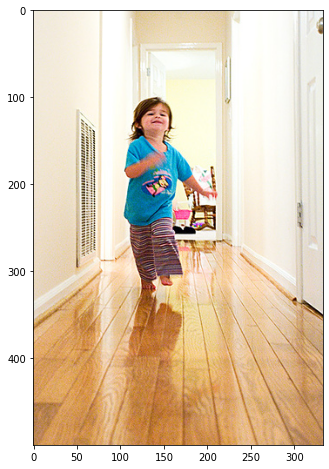


Reference captions:
--------------------------------------------------------------------------------
- A little girl in pajamas runs down a hall with hardwood floors .
- A little girl is running down a hardwood floored hallway .
- A little girl running down a brighly lit hallway .
- A toddler is running down a hallway .
- A young girl runs down a hallway with wooden floors .

Prediction:
--------------------------------------------------------------------------------
- a young boy is bouncing on a skateboard in front of a large building



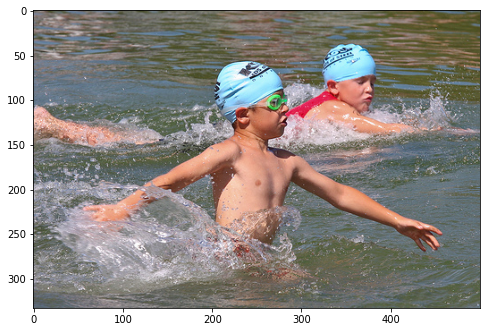


Reference captions:
--------------------------------------------------------------------------------
- A boy wearing a swimming cap and goggles running through water with another child swimming behind him .
- Some swimmers in the water .
- Two boys wearing matching blue swim caps swim in a lake .
- Two boys with blue swim caps in the murky water .
- Young boys wading in blue swim caps .

Prediction:
--------------------------------------------------------------------------------
- a man in a blue hat is being splashed in the water



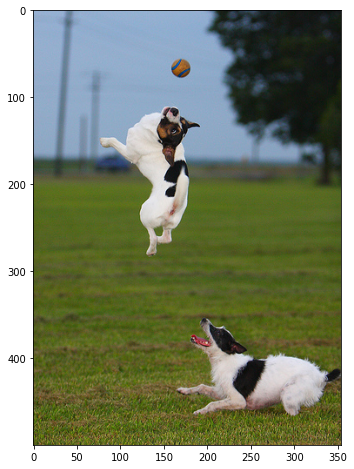


Reference captions:
--------------------------------------------------------------------------------
- One dog leaps to catch a softball while another looks on .
- The two dogs , one of which is leaping in the air , are chasing a ball outdoors .
- two dogs jump for a ball on a green field .
- Two dogs play catch with a ball in a field .
- Two small dogs pursuing a ball across a grassy field .

Prediction:
--------------------------------------------------------------------------------
- a black and white dog is catch a tennis ball



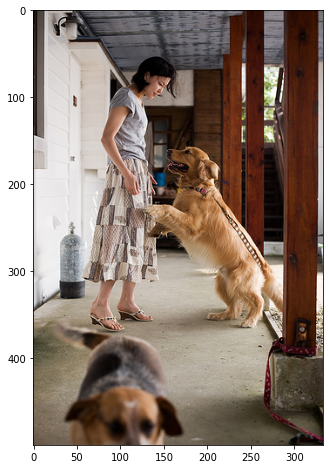


Reference captions:
--------------------------------------------------------------------------------
- a brown dog is jumping up at a woman who is wearing a brown skirt .
- A golden retriever is excitedly greeting a woman as a little dog walks towards the camera .
- A tan dog jumping up at a woman in a skirt and a black and tan dog walking away .
- A yellow dog jumps to greet a woman .
- One dog is jumping at the lady while the other walks away .

Prediction:
--------------------------------------------------------------------------------
- a dog is standing on a wooden ball



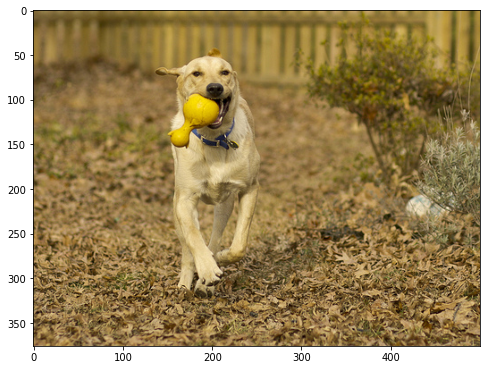


Reference captions:
--------------------------------------------------------------------------------
- A dog running with a toy in his mouth .
- A dog with a yellow toy in its mouth .
- A yellow dog running through a yard covered in leaves while holding a yellow toy in his mouth .
- Dog trotting with a rubber duck in its mouth
- The dog has retrieved his toy .

Prediction:
--------------------------------------------------------------------------------
- a dog running with a tennis ball in its mouth



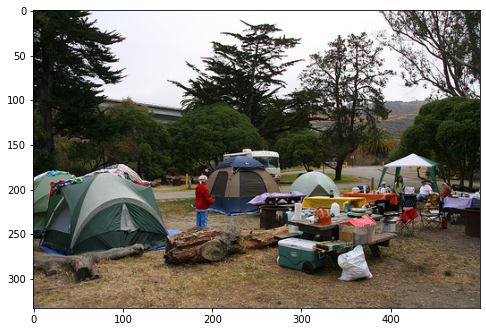


Reference captions:
--------------------------------------------------------------------------------
- A campsite has been established amidst the trees and bushes .
- A campsite with tents and picnic tables .
- A group of people camp in tents near some trees .
- A woman at a campground .
- People are camping in a group .

Prediction:
--------------------------------------------------------------------------------
- people are sitting on a tent with a tent



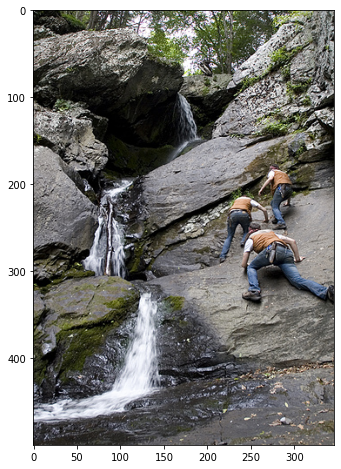


Reference captions:
--------------------------------------------------------------------------------
- Three climbers on rocks near waterfall .
- Three men climb a natural waterfall rock face .
- Three men in matching outfits climb a rock wall next to a waterfall .
- Three people are climbing rocks near a small waterfall .
- Three people rock climbing in matching clothes beside a small waterfall .

Prediction:
--------------------------------------------------------------------------------
- a man in a stream is standing in a river



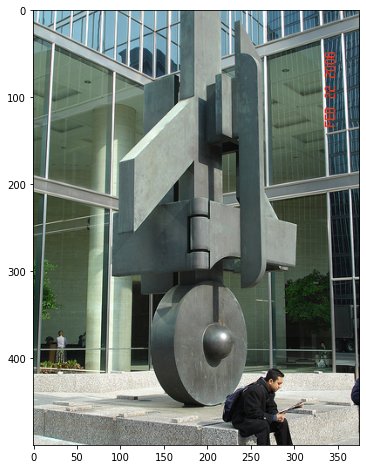


Reference captions:
--------------------------------------------------------------------------------
- A man in black is sitting next to a modern art structure in front of a glass building .
- A man sits and reads a newspaper by a sculpture outside of an office building .
- a man sits near a large statue .
- A man sitting in front of a metal sculpture in front of a building .
- The man with the backpack is sitting in a buildings courtyard in front of an art sculpture reading .

Prediction:
--------------------------------------------------------------------------------
- a few a man is riding a trick on a city



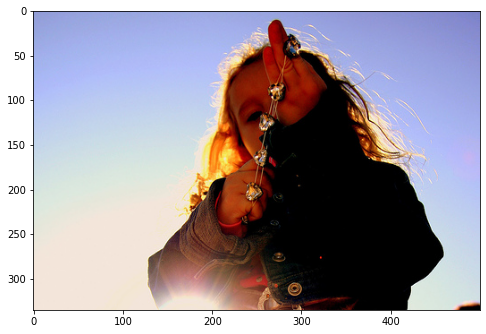


Reference captions:
--------------------------------------------------------------------------------
- A closeup of a girl holding a heart necklace and looking at it .
- A girl playing with a stretchy charm bracelet .
- A girl plays with a necklace as the sun shines behind her .
- A girl with the sun behind her plays with some jewelry .
- A little girl examines a piece of jewelry .

Prediction:
--------------------------------------------------------------------------------
- a girl in a white shirt is standing in front of a sign



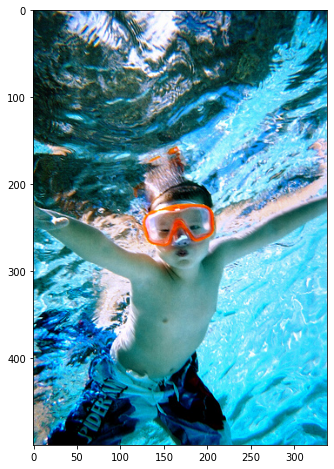


Reference captions:
--------------------------------------------------------------------------------
- A boy in an orange snorkel mask swims underwater .
- A kid is diving underwater while wearing swim gear and orange goggles .
- Boy swims underwater with orange mask on .
- The boy in red goggles swims underwater .
- The little boy swims under the water .

Prediction:
--------------------------------------------------------------------------------
- a young girl in a blue shirt is swimming in a pool



In [20]:
num_predictions = 10
for img_file_name in df_cap[df_cap['is_test']].sample(num_predictions)['image'].values:
    eval_image_from_test(img_file_name)
    print(f'{"="*80}\n')